In [6]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import pymc
from pymc import utils
from pymc.database import base

import glob

#plotting functions
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']  
vn_title_dict = {'massbal':'Mass Balance',                                                                      
                 'precfactor':'Precipitation Factor',                                                              
                 'tempchange':'Temperature Bias',                                                               
                 'ddfsnow':'DDF Snow'}
vn_label_dict = {'massbal':'Mass balance\n[mwea]',                                                                      
                 'precfactor':'Precipitation factor\n[-]',                                                              
                 'tempchange':'Temperature bias\n[degC]',                                                               
                 'ddfsnow':'DDFsnow\n[mwe $degC^{-1} d^{-1}$]'}
metric_title_dict = {'Gelman-Rubin':'Gelman-Rubin Statistic',
                     'MC Error': 'Monte Carlo Error',
                     'Effective N': 'Effective Sample Size'}
metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']

suffix = '_trunc'
mcmc_output_netcdf_fp = '../MCMC_data/netcdf' + suffix + '/'
mcmc_output_figures_fp = '../MCMC_data/figures' + suffix + '/'
mcmc_output_tables_fp = '../MCMC_data/tables/'
mcmc_output_csv_fp = '../MCMC_data/csv' + suffix + '/'
mcmc_output_hist_fp = '../MCMC_data/hist' + suffix + '/'

In [23]:
def assessment_vs_chain_length(iters, region='all', burn=0, mean=False):
    """
    Plot gelman-rubin statistic, effective_n (autocorrelation with lag
    100) and markov chain error plots.

    Takes the output from the Markov Chain model and plots the results
    for the mass balance, temperature change, precipitation factor,
    and degree day factor of snow.  Also, outputs the plots associated
    with the model.

    Parameters
    ----------
    iters : int
        Number of iterations associated with the Markov Chain
    burn : list of ints
        List of burn in values to plot for Gelman-Rubin stats

    Returns
    -------
    .png files
        saves figure showing how assessment values change with
        number of mcmc iterations
    """

    # hard code some variable names (dirty solution)
    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']
    vn_title_dict = {'massbal':'Mass Balance',
                     'precfactor':'Precipitation Factor',
                     'tempchange':'Temperature Bias',
                     'ddfsnow':'DDF Snow'}
    metric_title_dict = {'Gelman-Rubin':'Gelman-Rubin Statistic',
                         'MC Error': 'Monte Carlo Error',
                         'Effective N': 'Effective Sample Size'}
    metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']
    vn_label_dict = {'massbal':'[mwea]',
                     'precfactor':'[-]',
                     'tempchange':'[degC]',
                     'ddfsnow':'[mwe $degC^{-1} d^{-1}$]'}


    if mean:
        # find mean values
        # find all netcdf files (representing glaciers)
        if region == 'all':
            regions = ['13', '14', '15']
            filelist = []
            for reg in regions:
                filelist.extend(glob.glob(mcmc_output_netcdf_fp + str(reg) + '*.nc'))
        else:
            filelist = glob.glob(mcmc_output_netcdf_fp + str(region) + '*.nc')

        mean_dict = {}

        for vn in variables:
            mean_dict[vn] = []

        for netcdf in filelist:

            print(netcdf)

            try:
                # open dataset
                ds = xr.open_dataset(netcdf)

                for vn in variables:
                    mean_dict[vn].append(abs(np.mean(ds['mp_value'].sel(chain=0, mp=vn).values)))

            except:
                print('Error: ', netcdf)
                pass

        # calculate total mean
        for vn in variables:
            mean_dict[vn] = np.mean(mean_dict[vn])



    # hard code font sizes
    ticks=10
    suptitle=14
    title=10
    titley = 1.05
    label=10
    plotline=2
    plotline2=1
    legend=10
    figsize=(6.5, 9)
    dpi=100
    hspace=0.4
    wspace=0.4
    sup_y = 0.97
    nrows=4
    ncols=3
    num_stds=1
    alpha = 0.7
    s_alpha = 0.5
    cutoffstyle = '--'
    cutoffcolor = 'black'
    cutoffwidth = 1.5
    num_stds = 2
    #colors = ['#614684', '#ddc73e', '#ff6135']
    colors = ['#387ea0', '#fcb200', '#d20048']
    xmin = 0.025
    xmax = 0.975

    # bins and ticks
    bdict = {}
    tdict = {}

    plt.figure(figsize=figsize, dpi=dpi)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    m_len = len(metrics)
    v_len = len(variables)

    # create subplot for each variable
    for v_count, vn in enumerate(variables):

        df_dict = {}
        df_dict['Effective N'] = pd.read_csv(mcmc_output_csv_fp + vn + '_effective_n_df.csv').drop('Unnamed: 0', 1)
        df_dict['MC Error'] = pd.read_csv(mcmc_output_csv_fp + vn + '_mc_error_df.csv').drop('Unnamed: 0', 1)
        df_dict['normalized MC Error'] = pd.read_csv(mcmc_output_csv_fp +
                vn + '_normalized_mc_error_df.csv').drop('Unnamed: 0', 1)
        df_dict['Gelman-Rubin'] = pd.read_csv(mcmc_output_csv_fp + vn + '_gelman_rubin_df.csv').drop('Unnamed: 0', 1)

        #create subplot for each metric
        k = 0
        for m_count, metric in enumerate(metrics):

            if metric == 'MC Error' and (vn == 'precfactor' or vn == 'ddfsnow'):
                df = df_dict['normalized ' + metric]#.drop('Unnamed: 0', 1)
            else:
                df = df_dict[metric]#.drop('Unnamed: 0', 1)
            x = df.columns.values.astype(int)
            u_quantile = df.quantile(q=0.95).values
            l_quantile = df.quantile(q=0.05).values
            mean = df.mean().values
            median = df.median().values
            std = df.std().values

            # plot histogram
            ax = plt.subplot(nrows, ncols, m_len*v_count+m_count+1)

            ax.plot(x, mean, alpha=alpha, color=colors[k])

            #plot error region
            #ax.fill_between(x, mean + (num_stds * std), mean - (num_stds * std), alpha=s_alpha)
            ax.fill_between(x, u_quantile, l_quantile, alpha=s_alpha, color=colors[k])

            # niceties
            if v_count == 0:
                plt.title(metric_title_dict[metric], fontsize=title, y=titley)

            ylabel = ''
            # axis labels
            #if metric == 'MC Error' and (vn == 'tempchange' or vn == 'massbal'):
            #    ylabel = metric + ' ' + vn_label_dict[vn]
            #elif metric == 'MC Error':
            #    ylabel = metric + ' [%]'
            #else:
            #    ylabel = metric

            if m_count == 0:
                ax.set_ylabel(vn_title_dict[vn], fontsize=label, labelpad=10)
            #else:
                #ax.set_ylabel(ylabel, fontsize=label)

            if metric == 'Effective N':
                ax.set_ylim(bottom=0, top=1000)
                ax.axhline(y=100, xmin=xmin, xmax=xmax, color=cutoffcolor, linestyle=cutoffstyle, linewidth=cutoffwidth)
                #ticks = [item for item in ax.get_yticklabels()]
                #print(ticks)
            if metric == 'Gelman-Rubin':
                ax.set_ylim(bottom=1.0, top=1.12)
                ax.axhline(y=1.1, xmin=xmin, xmax=xmax, color=cutoffcolor, linestyle=cutoffstyle, linewidth=cutoffwidth)
            if metric == 'MC Error' and (vn == 'precfactor' or vn == 'ddfsnow'):
                ax.axhline(y=5, xmin=xmin, xmax=xmax, color=cutoffcolor, linestyle=cutoffstyle, linewidth=cutoffwidth)

            ax.set_xticks(np.arange(0, 31000, 10000))
            
            majorLocator = MultipleLocator(10000)
            minorLocator = MultipleLocator(2000)
            
            ax.xaxis.set_major_locator(majorLocator)
            ax.xaxis.set_minor_locator(minorLocator)
            
            def format_func(value, tick_number):
                # find number of multiples of pi/2
                N = int(value)
                return str(int(N/1000))


            ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
            #ax.xaxis.set_major_formatter(majorFormatter)
            
            if v_count==3:
                ax.set_xlabel('Steps [$10^3$]')

            k += 1

    # Save figure
    plt.savefig(mcmc_output_figures_fp + 'assessment_vs_chain_length.png',
                bbox_inches='tight')


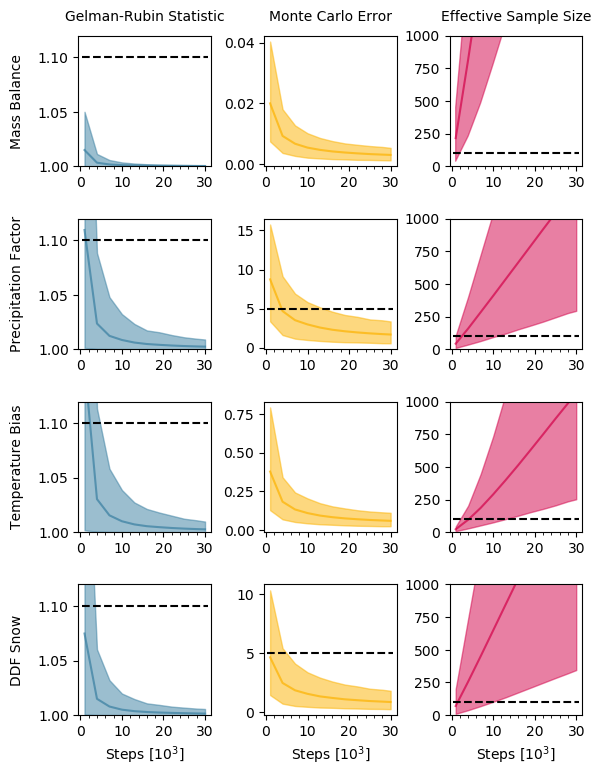

In [24]:
iterations = np.arange(1000, 31000, 3000)
iterations = np.append(iterations, 30000)
assessment_vs_chain_length(iters=iterations, region='all', burn=0)

In [70]:
region_no = 15.02793
csv_path = '../DEMs/Shean_2018_0806/hma_mb_20180803_1229.csv'
ds_all = pd.read_csv(csv_path)                                                                                    
ds_all[ds_all['RGIId'] == region_no]['mb_mwea'].values[0]

-0.088000000000000009

In [72]:
ds_all[ds_all['RGIId'] == region_no]['mb_mwea_sigma'].values[0]

0.27800000000000002

In [71]:
ds_all

,RGIId,x,y,z_med,z_p16,z_p84,z_slope,z_aspect,mb_mwea,mb_mwea_sigma,...,mb_m3wea,mb_m3wea_sigma,t1,t2,dt,H_m,debris_m,perc_debris,perc_pond,perc_clean
0,15.05152,-145758.234,-820691.042,7832.993,7700.992,8033.181,36.869,29.543,0.231,0.270,...,156577.742,183504.858,2000.412,2018.412,18,22.339,NaN,0.000,0.000,100.000
1,15.02793,307937.214,-927265.323,7687.041,7536.363,7853.120,32.953,318.297,-0.088,0.278,...,-108756.305,343880.009,2000.412,2018.412,18,23.749,NaN,0.000,0.000,100.000
2,15.02790,305153.261,-927260.154,7682.833,7509.912,7753.357,18.840,79.046,-0.047,0.268,...,-90371.014,514953.763,2000.412,2018.412,18,37.636,NaN,0.000,0.000,100.000
3,15.05153,-146725.010,-821804.519,7679.389,7494.941,7912.212,28.872,208.089,0.712,0.277,...,920416.473,366834.004,2000.412,2018.412,18,36.293,0.273,1.724,0.000,98.276
4,15.02827,308784.358,-927669.239,7668.919,7483.279,7881.574,46.917,98.424,0.488,0.299,...,278932.100,172838.883,2000.412,2018.412,18,23.579,NaN,0.000,0.000,100.000
5,15.02828,310683.424,-929789.103,7547.470,7338.876,7662.285,47.573,46.406,0.736,0.290,...,276184.637,111505.212,2000.412,2018.412,18,16.140,NaN,NaN,NaN,NaN
6,14.19942,-927804.005,-35168.378,7485.054,7405.273,7666.429,18.354,93.928,-0.150,0.269,...,-423785.487,758466.048,2000.412,2018.412,18,46.905,NaN,0.182,0.000,99.818
7,14.23897,-1157128.322,106023.793,7411.674,7335.080,7497.418,40.152,325.337,0.097,0.268,...,9876.137,27352.264,2000.412,2018.412,18,16.550,NaN,NaN,NaN,NaN
8,15.05141,-44297.109,-837269.979,7330.808,6972.165,7474.107,25.579,310.755,-0.617,0.274,...,-968224.317,437868.093,2000.412,2018.412,18,35.107,0.162,4.946,0.000,95.054
9,14.06796,-752458.804,18037.549,7274.240,7118.639,7574.369,45.367,213.483,-0.327,0.282,...,-120148.892,104426.060,2000.412,2018.412,18,19.682,NaN,NaN,NaN,NaN
